# Machine learning: exam assignment


### Predicting Marvel vs DC

#### Student: Jeroen Van Sweeveldt
##### Assignment: binary classification, predicting the creator of the respective superhero using the 'history_text' feature.
##### Part 4: training neural network 2: DistilBERT

Note: using Transformers architecture was not part of the assignment. This technology was handled during the subsequent course *Natural Language Processing*, but I wanted to update mine with one anyway out of curiousity to see how it would perform. Parts of the workflow follow the instructions laid out by HuggingFace: https://huggingface.co/transformers/v3.4.0/custom_datasets.html#seq-imdb.

### 1 Model preparation

In [ ]:
# perform magic command to remove all output text

%%capture
!pip install transformers datasets
!pip install transformers[torch] -U
!pip install accelerate -U

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/University/machine_learning/exam

Mounted at /content/gdrive
/content/gdrive/MyDrive/University/machine_learning/exam


In [ ]:
# imports for data exploration
import numpy as np
import pandas as pd

# imports for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# imports for model preparation
import sklearn
from sklearn.model_selection import train_test_split

# imports for PyTorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# imports for DistilBERT model
import transformers
from transformers import DistilBertForSequenceClassification, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.trainer_utils import EvalPrediction
from transformers import DistilBertTokenizer

from datasets import load_metric

# imports for evaluation
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# set seed for reproducability
torch.manual_seed(256)
np.random.seed(256)

# imports for function annotation
from typing import List, Tuple, Any, Union

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}", end="\n\n")

print(f"Torch == {torch.__version__}")
print(f"Transformers == {transformers.__version__}")
print(f"SKLearn == {sklearn.__version__}")

Using device: cuda

Torch == 2.2.1+cu121
Transformers == 4.40.0
SKLearn == 1.2.2


In [ ]:
heroes = pd.read_csv("data/heroes_preprocessed.csv",
                     encoding="UTF-8",
                     usecols=["hist_text_bert",
                              "label"
                              ]):

In [ ]:
heroes.sample(10)

,hist_text_bert,label
807,"Leaving the two of them to face each other, wi...",1
936,"However, the Hulk was not destined for a happy...",1
903,"Severing ties with Doctor Strange, Daimon batt...",1
2069,"Using Tabur's discarded amulet, Greer was even...",1
1509,Lorna and Alex returned from time to time to a...,1
439,Little is known of the life of mutant shape-ch...,1
588,Dr. Simon Ecks is a scientist who discovered t...,0
725,Norbert Ebersol was a child prodigy with such ...,1
1149,Knockout was a former Female Fury from Apokoli...,0
2206,"After meeting her crew, and saving one of them...",1


In [ ]:
# account for the data imbalance
c_weights = torch.tensor([1.45, 1.0])

In [ ]:
X_text = heroes.hist_text_bert
y_label = heroes.label


X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_text, y_label, test_size=0.2,
                                                    random_state=256, stratify=y_label)

X_dev, X_test, y_dev, y_test = train_test_split(X_dev_test, y_dev_test, test_size=0.5,
                                                    random_state=256, stratify=y_dev_test)

X_train.shape, X_dev.shape, X_test.shape, y_train.shape, y_dev.shape, y_test.shape

((1853,), (232,), (232,), (1853,), (232,), (232,))

In [ ]:
model_name = "distilbert-base-uncased"
model = transformers.DistilBertForSequenceClassification.from_pretrained(model_name,
                                                                         num_labels=2)
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
max_length = 512

train_encodings = tokenizer(X_train.tolist(), max_length=max_length, truncation=True, padding=True)
dev_encodings = tokenizer(X_dev.tolist(), max_length=max_length, truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), max_length=max_length, truncation=True, padding=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max(len(encoding) for encoding in train_encodings["input_ids"])

512

In [ ]:
class HeroesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["label"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HeroesDataset(train_encodings, y_train.tolist())
dev_dataset = HeroesDataset(dev_encodings, y_dev.tolist())
test_dataset = HeroesDataset(test_encodings, y_test.tolist())

In [ ]:
type(train_dataset)

__main__.HeroesDataset

In [ ]:
train_dataset[3]

{'input_ids': tensor([  101, 11789,  2003,  1996, 12608,  1998,  2298,  1011, 11455,  1997,
         22827,  1010,  1037,  2822,  8284,  2040,  2973,  5560,  2028,  4595,
          2086,  3283,  1998,  2001,  1037,  3076,  1997,  1996, 27906,  1012,
         22827,  2001,  2036,  1037,  3836,  1998,  1037, 19783,  1010,  1998,
          2295,  2010,  2344,  1997,  9978,  2001,  7422,  2000,  1996,  3971,
          1997,  3521,  1010,  2002,  2001,  2036,  1037,  8066,  3993,  6750,
          2040,  2052,  2954,  2043,  4072,  1012,  2028,  2154, 22827,  3603,
          1037,  4326,  3379,  1012, 11131,  2009,  1010, 22827,  2001,  4567,
          2114,  2010,  2097,  2083,  1037, 17529,  2304,  5259,  2046,  2019,
          2060, 22172,  6132, 19301,  8391,  1012,  2045, 22827,  2777, 15333,
          4819,  1010,  2332,  1997,  2909,  8524,  2099,  1010,  2010,  2905,
          1010,  4615, 20474, 19145,  2099,  1010,  1998,  2037,  2457, 16669,
          1010, 24728,  3070,  1010,  1

In [ ]:
load_accuracy = load_metric("accuracy", trust_remote_code=True)

def compute_metrics(eval_pred: Tuple[np.ndarray, np.ndarray]) -> float:
    """
    Computes the evaluation metrics based on predictions
    and ground truth labels. It takes the predictions and labels
    as input and then finds the index of the maximum value
    in each row of the predictions to convert probabilities in class predictions.

    Arguments:
        eval_pred (Tuple[np.ndarray, np.ndarray]): the predictions and labels to be evaluated.
        The tuple contains predictions made by the model as its first element,
        and the corresponding ground truth labels as its second element.

    Returns:
        A float value representing the computed evaluation metric.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    return load_accuracy.compute(predictions=predictions, references=labels)

In [ ]:
num_epochs=20
model.config.dropout = 0.85

training_args = TrainingArguments(output_dir=(f"model/distilbert_uncased"),
                                  learning_rate=1e-6,
                                  num_train_epochs=num_epochs,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=64,
                                  overwrite_output_dir=True,
                                  load_best_model_at_end=True,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  warmup_steps=500,
                                  gradient_checkpointing=False,
                                  weight_decay=0.01,
                                  max_grad_norm=1.0,
                                  seed=256
                                  )

### 2 5-fold cross validation

In [ ]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=256)
accuracy_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_text, y_label)):
    print(f"Fold {fold + 1}/{num_folds}")

    # split data into train and validation sets for current fold
    X_train_fold, X_val_fold = X_text[train_index], X_text[val_index]
    y_train_fold, y_val_fold = y_label[train_index], y_label[val_index]

    # tokenize data for current fold
    train_encodings_fold = tokenizer(X_train_fold.tolist(), max_length=max_length, truncation=True, padding=True)
    val_encodings_fold = tokenizer(X_val_fold.tolist(), max_length=max_length, truncation=True, padding=True)

    # create datasets for current fold
    train_dataset_fold = HeroesDataset(train_encodings_fold, y_train_fold.tolist())
    val_dataset_fold = HeroesDataset(val_encodings_fold, y_val_fold.tolist())

    # define Trainer for current fold
    trainer_fold = transformers.Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset_fold,
        eval_dataset=val_dataset_fold,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
    )

    trainer_fold.add_callback(EarlyStoppingCallback(early_stopping_patience=3))

    # train the model for current fold
    trainer_fold.train()


    # evaluate the model on validation set for current fold
    eval_results = trainer_fold.evaluate()
    accuracy_scores.append(eval_results['eval_accuracy'])

# compute mean validation accuracy across all folds
mean_accuracy = sum(accuracy_scores) / num_folds
print(f"Mean validation accuracy across {num_folds} folds: {mean_accuracy}")

Fold 1/5


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.671627,0.586207
2,No log,0.586851,0.625000
3,0.656400,0.360450,0.890086
4,0.656400,0.236865,0.924569
5,0.351600,0.190246,0.928879
6,0.351600,0.172564,0.931034
7,0.169200,0.162348,0.937500
8,0.169200,0.157869,0.939655
9,0.120600,0.159347,0.935345
10,0.120600,0.165418,0.935345


Fold 2/5


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.110553,0.963362
2,No log,0.104258,0.961207
3,0.119700,0.104582,0.963362
4,0.119700,0.107574,0.961207
5,0.103900,0.109529,0.967672


Fold 3/5


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.097639,0.963283
2,No log,0.096901,0.963283
3,0.107300,0.095229,0.965443
4,0.107300,0.099753,0.967603
5,0.092000,0.100294,0.965443
6,0.092000,0.102368,0.967603


Fold 4/5


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.073959,0.974082
2,No log,0.083821,0.971922
3,0.092900,0.078098,0.976242
4,0.092900,0.094722,0.969762


Fold 5/5


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.059805,0.982721
2,No log,0.057085,0.980562
3,0.094200,0.061218,0.980562
4,0.094200,0.061491,0.980562
5,0.079900,0.061502,0.980562


Mean validation accuracy across 5 folds: 0.964189692410814


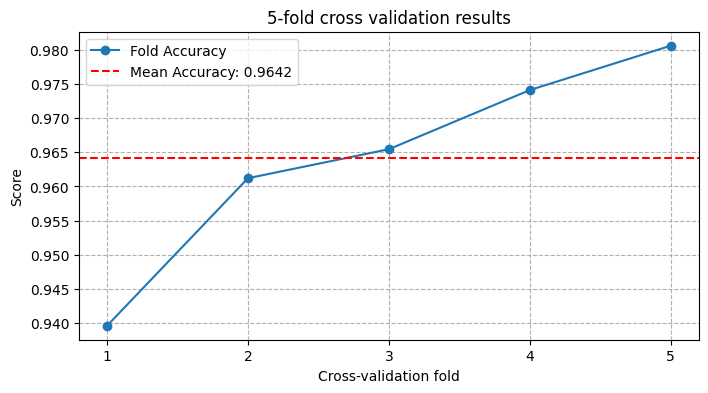

In [ ]:
mean_accuracy = np.mean(accuracy_scores)

plt.figure(figsize=(8, 4))

plt.plot(range(1, num_folds + 1),
         accuracy_scores,
         marker='o',
         linestyle='-',
         label='Fold Accuracy'
         )
plt.axhline(y=mean_accuracy,
            color="r",
            linestyle="--",
            label=f"Mean Accuracy: {mean_accuracy:.4f}"
            )
plt.title("5-fold cross validation results")
plt.xlabel('Cross-validation fold')
plt.ylabel('Score')
plt.xticks(range(1, num_folds + 1))
plt.grid(True, linestyle="--")
plt.legend()
plt.show()

### 3 Model training

In [ ]:
trainer = transformers.Trainer(model=model,
                               args=training_args,
                               train_dataset=train_dataset,
                               eval_dataset=dev_dataset,
                               compute_metrics=compute_metrics,
                               tokenizer=tokenizer
                               )

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.669589,0.594828
2,No log,0.583643,0.625000
3,0.656500,0.367457,0.870690
4,0.656500,0.250586,0.892241
5,0.355700,0.191855,0.918103
6,0.355700,0.171612,0.931034
7,0.170300,0.166007,0.922414
8,0.170300,0.160460,0.931034
9,0.125000,0.164638,0.931034
10,0.125000,0.161523,0.935345


TrainOutput(global_step=2552, training_loss=0.2786061354565396, metrics={'train_runtime': 308.2624, 'train_samples_per_second': 120.222, 'train_steps_per_second': 15.052, 'total_flos': 2700082986805248.0, 'train_loss': 0.2786061354565396, 'epoch': 11.0})

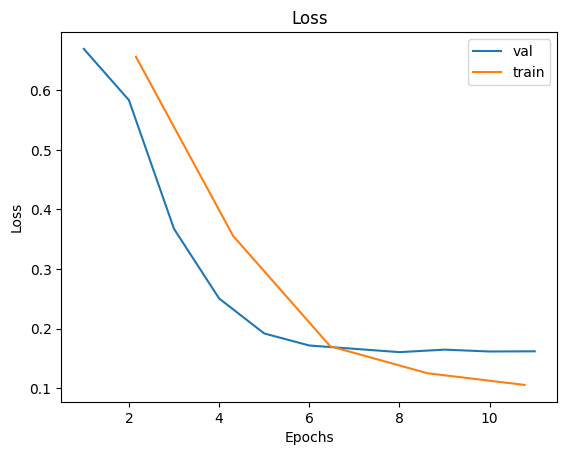

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
fig, ax = plt.subplots()

sns.lineplot(data=logs, x='epoch', y='eval_loss', label='val', zorder=2)
sns.lineplot(data=logs, x='epoch', y='loss', label='train', zorder=2)

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        95
           1       0.94      0.98      0.96       137

    accuracy                           0.95       232
   macro avg       0.96      0.95      0.95       232
weighted avg       0.95      0.95      0.95       232



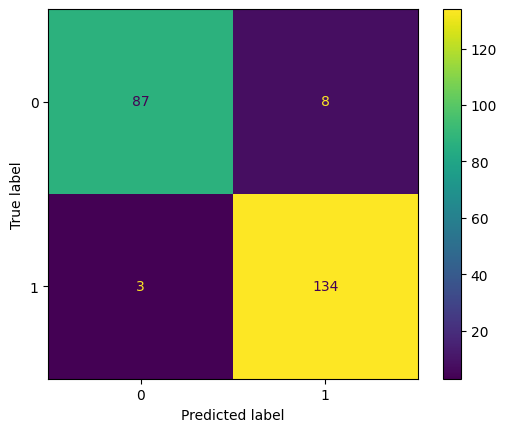

In [ ]:
print(classification_report(y_pred=y_preds, y_true=y_test))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_preds);

#### 3.1 Model training using balanced weights

We will now update our trainer with a custom loss function that accounts for the weight imbalance. An error analysis of the model run in **section 3** of this notebook revealed that apart from one example, all erronous classifications were assigned to the majority label (Marvel Comics). The lower recall score for the minority class shows that there is a bias towards the majority class. Thus, balancing the weights will yield a small boost in accuracy.

We cannot simply pass our custom weights to the Transformer's training arguments, similar to how we passed those weigths in the LSTM model, under the **loss** function. We'll have to create our custom class object to achieve this.

The class ClassWeightsTrainer first extracts the labels from the input dictionary, that are stored under the key 'labels'.

In the forward pass, the input data is passed through the layers of the neural network to obtain the predictions. The double asterisk in model(** inputs) means the unpacking of the input dictionary and is equivalent to writing **model(input_ids=[1, 2, 3], attention_mask=[1, 1, 1])**.

The output produces **logits** -- the raw scores, values before they are transformed by a softmax function -- for each class. These logits are extracted from the dictionary, where they are stored under the key 'logits'.

Next, when computing the custom loss, we define a loss function (Cross entropy loss, which is commonly used for multi-class classification problems such as this one), and we specify the class weights that were calculated and converted into a tensor at the beginning of this notebook and stored under the variable **c_weights**. We then call the **.to(device)** method to ensure that the class weights tensor is on the same device (GPU or CPU) as the model and input data. Neglecting this will likely throw a Runtime Error.

After defining the loss function, we calculate the loss function, through which the logits and labels are passed. The **view(-1, self.model.config.num_labels)** part reshapes the logits to have a shape of (batch_size, num_labels) where the batch_size is inferred from the data and num_labels is the number of classes in the classification task.

Finally, we return the calculated loss. If **return_outputs** has been flagged as True when calling the compute_loss method, it will return an output dictionary containing the model's predictions. Otherwise, it only returns the loss.

In [ ]:
class ClassWeightsTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")

        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # compute custom loss based on calculated weight balance
        loss_func = nn.CrossEntropyLoss(weight=c_weights.to(device))
        loss = loss_func(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
trainer = ClassWeightsTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
    )

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=3))


trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.682148,0.702586
2,No log,0.607839,0.818966
3,0.668800,0.367767,0.892241
4,0.668800,0.248982,0.905172
5,0.355600,0.192503,0.939655
6,0.355600,0.173406,0.939655
7,0.171300,0.169399,0.931034
8,0.171300,0.164796,0.935345
9,0.128600,0.171586,0.931034
10,0.128600,0.168660,0.935345


TrainOutput(global_step=2552, training_loss=0.28185753426208016, metrics={'train_runtime': 895.9244, 'train_samples_per_second': 41.365, 'train_steps_per_second': 5.179, 'total_flos': 2700082986805248.0, 'train_loss': 0.28185753426208016, 'epoch': 11.0})

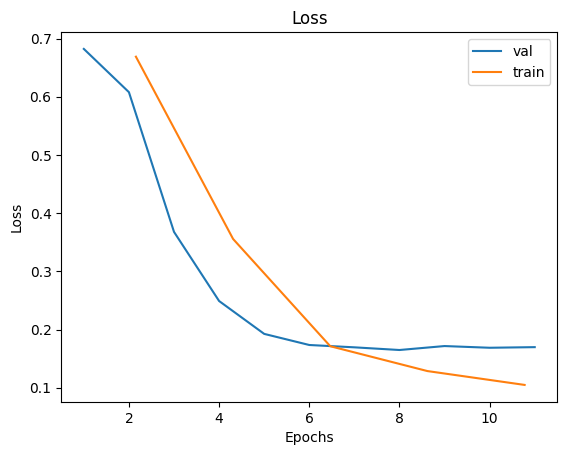

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
fig, ax = plt.subplots()

sns.lineplot(data=logs, x='epoch', y='eval_loss', label='val', zorder=2)
sns.lineplot(data=logs, x='epoch', y='loss', label='train', zorder=2)

plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [ ]:
y_pred = trainer.predict(test_dataset)
y_pred_metrics = y_pred.metrics

y_preds = np.argmax(y_pred.predictions, axis=1)
y_true = y_test.tolist()

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        95
           1       0.97      0.97      0.97       137

    accuracy                           0.97       232
   macro avg       0.96      0.96      0.96       232
weighted avg       0.97      0.97      0.97       232



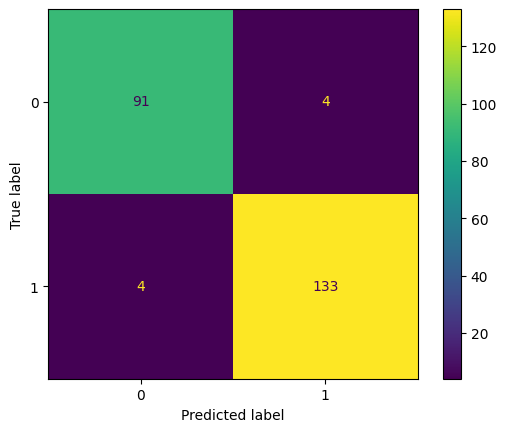

In [ ]:
print(classification_report(y_pred=y_preds, y_true=y_test))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_preds);

In [ ]:
# save the model

trainer.save_model(f"model/results/ft_distilbert_uncased")

### 4 Error analysis

In [ ]:
results_distilbert = pd.DataFrame({"hist_text_classic": X_test,
                            "true_label": y_test,
                            "predicted_label": y_preds,
                            "result": ["Correct" if true == pred else "Incorrect" for true, pred in zip(y_test, y_preds)],
                            "n_words": [len(text.split()) for text in X_test]
                            })

results_distilbert.true_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)
results_distilbert.predicted_label.replace({0: "DC Comics", 1: "Marvel Comics"}, inplace=True)

In [ ]:
results_distilbert.to_csv("data/error_distilbert.csv",
                    index=False)

In [ ]:
results_distilbert[results_distilbert["result"]=="Incorrect"]

,hist_text_classic,true_label,predicted_label,result,n_words
155,"Albert ""Al"" Rothstein (died October 6, 2015), ...",DC Comics,Marvel Comics,Incorrect,27
289,It was at this time that Dane acquired one of ...,Marvel Comics,DC Comics,Incorrect,135
1048,Billy Russo was the son to a meth addict. He w...,Marvel Comics,DC Comics,Incorrect,158
976,Incubus was an inter-dimensional mystical bein...,DC Comics,Marvel Comics,Incorrect,153
39,Ajax (born Francis Freeman) was a human who ga...,Marvel Comics,DC Comics,Incorrect,25
1286,"Centuries ago on the planet Ma'aleca'andra, th...",DC Comics,Marvel Comics,Incorrect,442
1378,"Spector's father, a rabbi, managed to escape G...",Marvel Comics,DC Comics,Incorrect,448
1289,While operating under the guise of William Dye...,DC Comics,Marvel Comics,Incorrect,103
